In [5]:
# !conda install -c conda-forge umap-learn
!pip install icecream
!pip install textalloc
!pip install umap-learn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 88 kB 24.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 99.9 MB/s eta 0:00:01
     |████████████████████████████████| 34.6 MB 91.3 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82820 sha256=496c420e9a688b5c651405dfd9817c5d3fa19dda1e59aa87e3efd10ced492acc
  Stored in directory: /tmp/pip-ephem-wheel-cache-nl4imrpw/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55496 sha256=f600a8e1943de5c66df6ae6ee6ac005bc50d2be38d3707f4fb57a736446bf6c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-nl4imrpw/wheels/19/bc/eb

In [4]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import umap
import math as mef
from icecream import ic
import textalloc as ta

ModuleNotFoundError: No module named 'umap'

In [3]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Visualizing the voltage traces obtained for cell C51A at various temperature using UMAP  

UMAP is a dimension reduction algorithm that tries to maintain the structure of the manifold underlying the data as good as possible. For a theoretical explanation of UMAP, see the document Theoretical_Explanation_UMAP.doc (which you can find in the same folder as this notebook) or visit https://umap-learn.readthedocs.io/en/latest/how_umap_works.html (the document is a summary of this web page).  

## Which variables will be compared? 

UMAP uses behavioural characteristics of a cell, for example a voltage trace, but these can also be used to classify behaviour simultaneously. This will hopefully make the classifying more exact.

Without spike: (STO)  
- Voltage (`v`)
- Calcium concentration (`caConc`)
- low-threshold calcium gating variables (`k`,`l`)
- calcium-dependent potassium gating variable (`z`)
- h current gating variable (`q`)

With spike:
- Voltage (`v`)
- Calcium concentration (`caConc`)
- Sodium gating variables (`m`,`h`)
- Potassium (dr) gating variable (`n`)
- low-threshold calcium gating variables (`k`,`l`)
- high-threshold calcium gating variable (`r`)
- calcium-dependent potassium gating variable (`z`)
- h current gating variable (`q`)

## Loading the data  
  
Characteristics of the simulation corresponding to the results visualized here (1_C51A.csv) can be found in *SimulationResults\datasets.xls*.  

In [27]:
sets = ['v','caConc','m','h','n','k','l','r','z','q'] 
#sets = ['v','caConc','m','h','n','k','l'] 
sets = ['v']
dend_meas = ['v','caConc','r','z','q']
axon_meas = ['v']
cell = "C11A"
exp = "nopulse_LONG"
#exp = "nopulse"
#exp = "pulse"
#exp = "clamps"
if len(sets) == 1:
    setname = 'vOnly'
else:
    setname = 'allVars'
if exp.__contains__('LONG'):
    tempran = "20.0to40.0"
else:
    tempran = "20to40"
transientless = True
if transientless == True:
    trantran = 'notran'
else:
    trantran = 'tran'
segs = [0]
useThese = True
if useThese == False:
    if cell == "C10" or cell == "C11A":
        segs = [0,6,200]
    else:
        segs = [0,5,200]
data_sets = []
for ss in segs:
    for sss in sets:
        if ss == 6 or ss == 5:
            if sss not in dend_meas:
                #ic(ss,sss)
                continue
        else:
            if sss in dend_meas and sss != 'v':
                #ic(ss,sss)
                continue
        if ss == 200:
            if sss not in axon_meas:
                #ic(ss,sss)
                continue
        thisset = cell+"_"+str(ss)+"_"+tempran+"_step0.1_"+sss+"_"+exp+".csv"
        #thisset = cell+"_"+str(ss)+"_20to40_step0.1_"+sss+"_"+exp+".csv"
        ic(thisset)
        setset = pd.read_csv(thisset,index_col=0)
        
        if transientless == True:
            if setset.shape[1] > 40000:
                # This line removes the long transient:
                setset = pd.DataFrame.transpose(pd.DataFrame.transpose(setset).iloc[40000:])
            else:
                # This line removes the short transient:
                setset = pd.DataFrame.transpose(pd.DataFrame.transpose(setset).iloc[2000:]) 
        
        if setset.shape[0] != 0:
            #ic(thisset)
            data_sets.append(setset)
        
#data_set = pd.read_csv("C11A_20to40_step5_all.csv", index_col=0)
#remove = []
#for i in range(0,2500):
    #toremove = i/10000
    #remove.append(str(toremove))
#remove = ['0.0']
#data_set = data_set.drop(remove, axis=1)



total_set = data_sets[0]
if len(sets) > 1:
    for ss in range(0,len(data_sets)-1):
        set1 = total_set
        set2 = data_sets[ss+1]
        total_set = pd.merge(set1,set2,left_index = True, right_index = True)
data_set = total_set
data_set.head()

ic| thisset: 'C11A_0_20.0to40.0_step0.1_v_nopulse_LONG.csv'


,4.0,4.0001,4.0002,4.0003,4.0004,4.0005,4.0006,4.0007,4.0008,4.0009,...,4.9991,4.9992,4.9993,4.9994,4.9995,4.9996,4.9997,4.9998,4.9999,5.0
20.0degC,-0.053520,-0.053210,-0.052889,-0.052558,-0.052216,-0.051864,-0.051501,-0.051128,-0.050745,-0.050351,...,-0.063229,-0.063203,-0.063176,-0.063150,-0.063123,-0.063095,-0.063067,-0.063039,-0.063011,-0.062982
20.1degC,-0.065895,-0.065862,-0.065830,-0.065799,-0.065769,-0.065741,-0.065714,-0.065688,-0.065662,-0.065638,...,-0.043307,-0.042728,-0.042113,-0.041447,-0.040702,-0.039832,-0.038739,-0.037201,-0.034551,-0.027797
20.2degC,-0.065344,-0.065350,-0.065356,-0.065362,-0.065369,-0.065375,-0.065381,-0.065387,-0.065393,-0.065400,...,-0.065128,-0.065130,-0.065132,-0.065134,-0.065136,-0.065138,-0.065141,-0.065144,-0.065147,-0.065150
20.3degC,-0.065975,-0.065977,-0.065980,-0.065982,-0.065985,-0.065987,-0.065989,-0.065991,-0.065993,-0.065995,...,-0.065995,-0.065997,-0.065999,-0.066001,-0.066003,-0.066005,-0.066006,-0.066008,-0.066010,-0.066011
20.4degC,-0.065363,-0.065354,-0.065346,-0.065338,-0.065329,-0.065321,-0.065313,-0.065304,-0.065295,-0.065287,...,-0.064977,-0.064966,-0.064955,-0.064944,-0.064933,-0.064922,-0.064910,-0.064899,-0.064888,-0.064876


In [34]:
phas_cor = True


if phas_cor:
    datT = pd.DataFrame.transpose(data_set)
    new_dat = {}
    for TT in datT:
        trac = datT[TT].iloc[:2000]
        mm  = max(trac)
        for timtim in range(0,trac.size):
            if trac[timtim] == mm:
                new_dat[TT] = list(datT[TT].iloc[timtim:timtim+8001])
    t = np.arange(0,0.8001,0.0001)
    fram = pd.DataFrame(new_dat,index=t)
    data_set = pd.DataFrame.transpose(fram)

## Choose your hyper parameters  
  
- I also tried `mahalanobis` distance, instead of `euclidean`, but it scatters all datapoints homogeneously over a disc in an extremely long run time.
- I tried between 2 and 30 nearest neighbours and found 15 to give the best results.

In [86]:
k = 45
m_d = 1
reducer = umap.UMAP(metric = 'euclidean', n_neighbors=k, min_dist=m_d)
embedding = reducer.fit_transform(data_set)

*Got lost in some esthetics here:* 

In [38]:
clrmap = plt.cm.gist_ncar
#clrmap = plt.cm.hsv

#plt.rcParams['figure.figsize'] = [10, 10]
#plt.figure()
#for i in np.linspace(0, 1, 100):
#    plt.plot(i,i,marker='o',color=tuple(clrmap(i)))
#plt.show()

#plt.figure()
#for i in np.linspace(0.1, 0.9, len(unique_labels)):
#    plt.plot(i,i,marker='o',markersize=20,color=tuple(clrmap(i)))
#plt.show()

## Plot the results

Number of clusters: 8


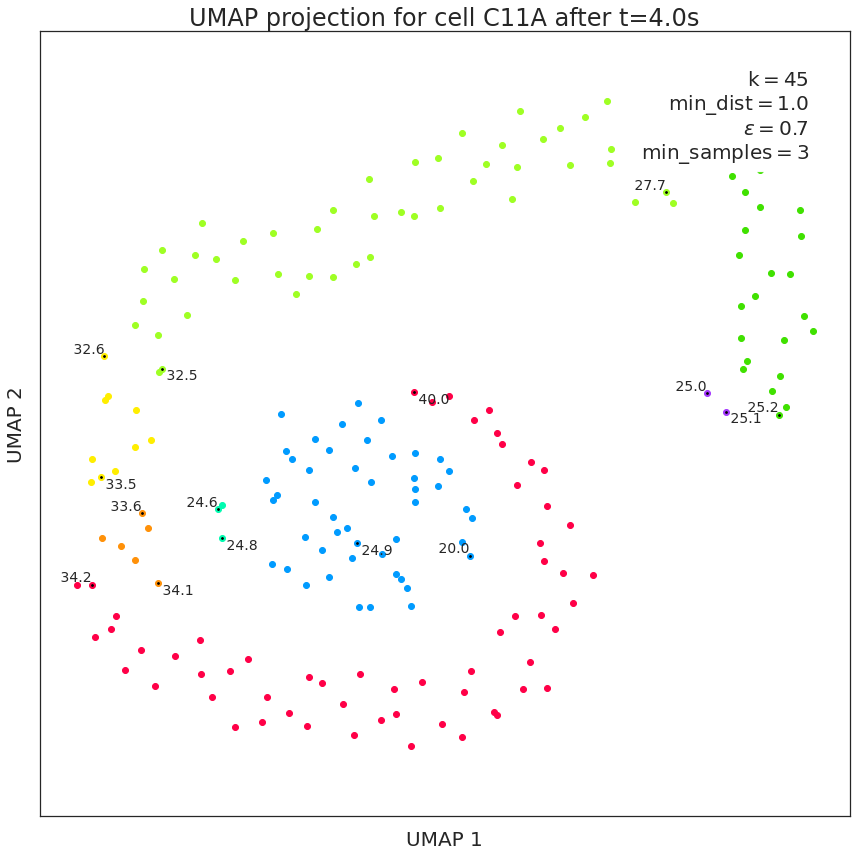

In [98]:
%matplotlib inline

epsilon = 0.732
m_s = 3
db = DBSCAN(eps=epsilon, min_samples=m_s).fit(embedding)
labels = db.labels_
unique_labels = set(labels)
colors = [clrmap(each) for each in np.linspace(0.15, 0.85, len(unique_labels))]
print("Number of clusters: " + str(len(unique_labels)))

plt.rcParams['figure.figsize'] = [12, 12]
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(labels)):
    col = colors[labels[i]]
    ax.scatter(embedding[i][0], embedding[i][1], color=tuple(col))
    
#Store the first and last simulation that is assigned to a cluster to obtain 
#the lowest and highest temperature belonging to one class

first = []
last = []

for cluster_label in unique_labels:
    for i in range(len(labels)):
        if labels[i] == cluster_label:
            first.append(data_set.iloc[i].name)
            ax.scatter(embedding[i][0], embedding[i][1], c="black", s=3)
            label = str(data_set.iloc[i].name)
            ax.annotate(" "+label[:4], xy=(embedding[i][0], embedding[i][1]), 
                        fontsize = 14, horizontalalignment='right', verticalalignment='bottom')
            break
    for i in range(len(labels)-1, -1, -1):
        if labels[i] == cluster_label:
            last.append(data_set.iloc[i].name)
            ax.scatter(embedding[i][0], embedding[i][1], c="black", s=3)
            label = str(data_set.iloc[i].name)
            ax.annotate(" "+label[:4], xy=(embedding[i][0], embedding[i][1]), 
                        fontsize = 14, verticalalignment='top')
            break

textstr = '\n'.join((
    r'$\mathrm{k}=%.0f$' % (int(k), ),
    r'$\mathrm{min\_dist}=%.1f$' % (m_d, ),
    r'$\epsilon=%.1f$' % (epsilon, ),
    r'$\mathrm{min\_samples}=%.0f$' % (m_s, )))

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(0.95, 0.89, textstr, transform=ax.transAxes, fontsize=20,
    verticalalignment='center',horizontalalignment='right', bbox=props)
            
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP projection for cell {cell} after t=4.0s', fontsize=24)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
plt.xlabel('UMAP 1',fontsize=20)
plt.ylabel('UMAP 2',fontsize=20)
plt.tight_layout()
plt.show()


## Plot traces corresponding to the lowest and highest temperature belonging to the class per class

ValueError: num must be 1 <= num <= 9, not 0

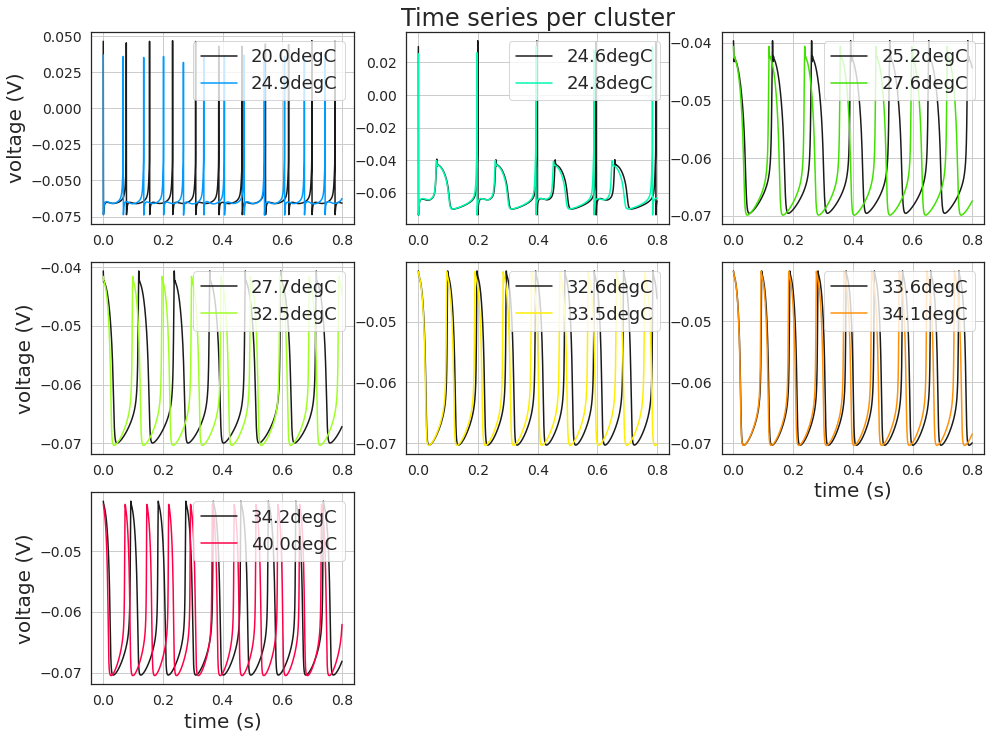

In [99]:
%matplotlib inline
n = mef.ceil(mef.sqrt(len(unique_labels)))
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
#plt.rc('font', size=22)

data_setT = pd.DataFrame.transpose(data_set)
colors_low = [clrmap(each-0.05) for each in np.linspace(0.05, 0.85, len(unique_labels))]
colors_high = [clrmap(each+0.05) for each in np.linspace(0.05, 0.85, len(unique_labels))]

fig = plt.figure()
plt.title('Time series per cluster', fontsize=24)
plt.box(on=None)
plt.axis('off')


for cluster_label in unique_labels:
    ax = fig.add_subplot(n, n, cluster_label+1)
    col = colors[cluster_label]
    col_low = colors_low[cluster_label]
    col_high = colors_high[cluster_label]
    #data_setT[[first[cluster_label], last[cluster_label]]].plot(color={tuple(col_low),tuple(col_high)})  
    data_setT[first[cluster_label]][:30001].plot(color='k') 
    data_setT[last[cluster_label]][:30001].plot(color=tuple(col)) 
    if cluster_label >= len(unique_labels)-n:
        plt.xlabel('time (s)', fontsize=20)
    if int((cluster_label + 1) % 3) == 1:
        plt.ylabel('voltage (V)', fontsize=20)
    
    if len(unique_labels)==1:
        #print("Here!")
        plt.axis('on')
        plt.xlabel('time (s)', fontsize=20)
        plt.ylabel('voltage (V)', fontsize=20)
    
    ax.legend([first[cluster_label], last[cluster_label]], fontsize=18,loc="upper right")
    ax.grid(True)
    #ax.set_xticks([0.25*5000, 0.5*5000, 0.75*5000, 1.0*5000])
    #ax.set_xticklabels(["0.25", "0.5", "0.75", "1.0"])
    #plt.title('Lowest and highest temperature samples belonging to cluster '+str(cluster_label), color=tuple(col))


plt.show()

## Subplot!

Let's try to make this all into one neat subplot;

ic| k: 45
ic| m_d: 1
ic| epsilon: 0.732
ic| m_s: 3


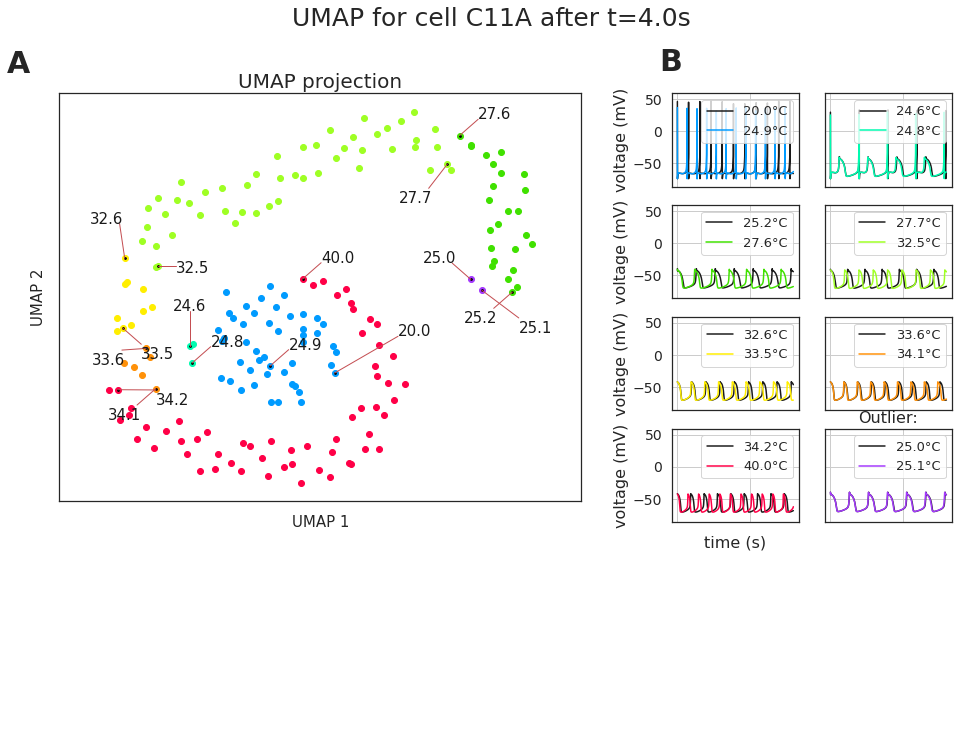

In [100]:
def find_optimal_layout(N):
    o_l = {1:(1,1),2:(2,1),3:(3,1),4:(4,1),5:(3,2),6:(3,2),7:(4,2),8:(4,2),9:(3,3),10:(4,3),11:(4,3),12:(4,3),13:(4,4),14:(4,4),15:(4,4),16:(4,4)}
    return o_l[N]

def find_numbers(n,m):
    base = []
    plots = []
    start = n
    for col in range(0,m):
        base.append(start+col+1)
    for count_n in range(0,n):
        for count_m in range(0,m):
            plots.append(base[count_m]+count_n*(n+m))
    return plots

def find_minmax(ds):
    minmin = 99999
    maxmax = -99999
    indexskipped = False
    for Tempeh in ds: #Tempeh is temperature
        if indexskipped == False:
            indexskipped = True
            continue 
        tractor = ds[Tempeh][:numsteps] #tractor is trace
        #ic(tractor)
        thismin = min(tractor)
        thismax = max(tractor)
        #ic(thismax)
        #ic(maxmax)
        if thismin < minmin:
            minmin = thismin
        if thismax > maxmax:
            maxmax = thismax
    #ic(minmin,maxmax)
    return minmin,maxmax

def find_title():
    #ic()
    if exp.__contains__('LONG'):
        title = f'UMAP for cell {cell} after t=4.0s'
    elif exp.__contains__('nopulse'):
        if setname.__contains__('all'):
            title = f"UMAP for cell {cell} using all traces"
        else:
            title = f"UMAP for cell {cell}"
    elif exp.__contains__('clamps'):
        title = f"UMAP for cell {cell}, exposed to voltage clamps"
    else:
        # When a pulse is given
        if setname.__contains__('all'):
            title = f"UMAP for cell {cell} using all traces, exposed to a current clamp"
        else:
            title = f"UMAP for cell {cell}, exposed to a current clamp"
    #ic(title)
    return title
 
ic(k)
ic(m_d)
ic(epsilon)
ic(m_s)

if transientless == True:
    if not exp.__contains__('LONG'):
        numsteps = 8001
    else: 
        numsteps = 10001
else:
    if exp.__contains__('clamps'):
        numsteps = 30001
    else:
        numsteps = 10001
    
minv, maxv = find_minmax(pd.DataFrame.transpose(data_set))

diff = maxv - minv
maxv = maxv + 0.1*diff
minv = minv - 0.1*diff

N = len(unique_labels)
n,m = find_optimal_layout(N)

fig,axes = plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios': [n*10-2*m, m*10], 'height_ratios': [n*10+2*m, m*10]})
for aa in range(0,len(axes)):
    for bb in range(0,len(axes)):
        if aa == 0 and bb == 0:
            donothing = True
        else:
            axes[aa,bb].axis('off')
ax = axes[0,0]
ax.set_aspect('equal', 'datalim')
#ax = fig.add_subplot(111)

for i in range(len(labels)):
    col = colors[labels[i]]
    ax.scatter(embedding[i][0], embedding[i][1], color=tuple(col))
    
#Store the first and last simulation that is assigned to a cluster to obtain 
#the lowest and highest temperature belonging to one class

first = []
last = []
first_traces = []
last_traces = []
labelslab = []

labels_locs = [[],[]]

for cluster_label in unique_labels:
    for i in range(len(labels)):
        if labels[i] == cluster_label:
            first.append(data_set.iloc[i].name)
            first_traces.append(data_set.iloc[i].name.split('degC')[0]+chr(176)+'C')
            ax.scatter(embedding[i][0], embedding[i][1], c="black", s=3)
            label = str(data_set.iloc[i].name)
            labelslab.append(label.split('degC')[0])
            labels_locs[0].append(embedding[i][0])
            labels_locs[1].append(embedding[i][1])
            #ax.annotate(" "+label[:4], xy=(embedding[i][0], embedding[i][1]), fontsize = 14, horizontalalignment='center', verticalalignment='bottom')
            break
    for i in range(len(labels)-1, -1, -1):
        if labels[i] == cluster_label:
            last.append(data_set.iloc[i].name)
            last_traces.append(data_set.iloc[i].name.split('degC')[0]+chr(176)+'C')
            ax.scatter(embedding[i][0], embedding[i][1], c="black", s=3)
            label = str(data_set.iloc[i].name)
            labelslab.append(label.split('degC')[0])
            labels_locs[0].append(embedding[i][0])
            labels_locs[1].append(embedding[i][1])
            #ax.annotate(" "+label[:4], xy=(embedding[i][0], embedding[i][1]), fontsize = 14, horizontalalignment='right',verticalalignment='bottom')
            break

# textstr = '\n'.join((
#     r'$\mathrm{k}=%.0f$' % (int(k), ),
#     r'$\mathrm{min\_dist}=%.1f$' % (m_d, ),
#     r'$\epsilon=%.1f$' % (epsilon, ),
#     r'$\mathrm{min\_samples}=%.0f$' % (m_s, )))

# props = dict(boxstyle='round', facecolor='white', alpha=1)
# ax.text(0.95, 0.89, textstr, transform=ax.transAxes, fontsize=20,
#     verticalalignment='center',horizontalalignment='right', bbox=props)
# plt.title(f'UMAP projection for cell {cell} after t=4.0s', fontsize=24)

ta.allocate_text(fig,ax,labels_locs[0],labels_locs[1],
            labelslab,
            x_scatter=embedding[:, 0], y_scatter=embedding[:, 1],
            max_distance=0.2,
            min_distance=0.04,
            margin=0.039,
            linewidth=1,
            nbr_candidates=400,
            textsize=15)

ax.set_title(f'UMAP projection', fontsize=20)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set_xlabel('UMAP 1',fontsize=15)
ax.set_ylabel('UMAP 2',fontsize=15)
ax.text(-0.1, 1.05, 'A', transform=ax.transAxes, 
            size=30, weight='bold')

test_x = np.linspace(0,1000,1000)
test_y = test_x

ax = axes[1]
plot_numbers = find_numbers(n,m)
#print(n+m,n+m,plot_numbers)
for cluster_label in unique_labels:
    ax = fig.add_subplot(n+m, n+m, plot_numbers[cluster_label])
    col = colors[cluster_label]
    col_low = colors_low[cluster_label]
    col_high = colors_high[cluster_label]
    #data_setT[[first[cluster_label], last[cluster_label]]].plot(color={tuple(col_low),tuple(col_high)})  
    (data_setT[first[cluster_label]][:numsteps]*1000).plot(color='k') 
    (data_setT[last[cluster_label]][:numsteps]*1000).plot(color=tuple(col))
    #ax.set_title(f'{first[cluster_label]} - {last[cluster_label]}')
    if cluster_label >= len(unique_labels)-m:
        plt.xlabel('time (s)', fontsize=16)
        lablablab = ax.get_xticklabels()
        labeltjes = []
        for ll in lablablab:
            value = ll.get_text().split('_')[0]
            labeltjes.append(value)
        #ic(labeltjes)
        ax.set_xticklabels(labeltjes)
    else:
        ax.set_xticklabels([])
    if int((cluster_label + 1) % m) == 1 or m == 1:
        plt.ylabel('voltage (mV)', fontsize=16)
    else:
        ax.set_yticklabels([])
    
    if len(unique_labels)==1:
        #print("Here!")
        plt.axis('on')
        plt.xlabel('time (s)', fontsize=20)
        plt.ylabel('voltage (mV)', fontsize=20)
    
    ax.set_ylim([minv*1000,maxv*1000])
    ax.legend([first_traces[cluster_label], last_traces[cluster_label]], fontsize=13,loc="upper right")
    if cluster_label == -1:
        ax.set_title("Outlier:")
    ax.grid(True)
    
    if cluster_label == 0:
        ax.text(-0.1, 1+(0.06*n), 'B', transform=ax.transAxes, 
            size=30, weight='bold')

fig.suptitle('Test')
        
#fig.tight_layout()
st = find_title()
plt.suptitle(st, fontsize=25)
#plt.show()

plt.savefig(f'./Figures/UMAP_{cell}_{setname}_{exp}_{trantran}_k{k}_md{m_d}_eps{epsilon}_ms{m_s}.png',bbox_inches='tight')